# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [14]:
# データ読み込み
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 初期データ確認
display(data.head())
display(data.info())


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991
2,2015-02-25,180000,10000,770,6,47.74,-122.23,1933,0
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [16]:
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# モデル用数値カラム
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df = data[numeric_cols].describe()
describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


C:\Users\rainb\AppData\Local\Temp\ipykernel_5156\139335511.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


,price,sqft_lot,sqft_living,grade,lat,long,yr_built,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation
count,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"540,088.14","15,106.97","2,079.90",7.66,47.56,-122.21,"1,971.01","2,014.32",6.57,302.19,0.04,0.78
std,"367,127.20","41,420.51",918.44,1.18,0.14,0.14,29.37,0.47,3.12,113.05,0.20,4.90
min,"75,000.00",520.00,290.00,1.00,47.16,-122.52,"1,900.00","2,014.00",1.00,122.00,0.00,-1.00
25%,"321,950.00","5,040.00","1,427.00",7.00,47.47,-122.33,"1,951.00","2,014.00",4.00,203.00,0.00,0.00
50%,"450,000.00","7,618.00","1,910.00",7.00,47.57,-122.23,"1,975.00","2,014.00",6.00,289.00,0.00,0.00
75%,"645,000.00","10,688.00","2,550.00",8.00,47.68,-122.12,"1,997.00","2,015.00",9.00,413.00,0.00,0.00
max,"7,700,000.00","1,651,359.00","13,540.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,512.00,1.00,80.00


上記の表から、`days_since_2014_01_01` や `renovated_flag`, `years_since_renovation` を含めた特徴量について、最大値・最小値・平均値などが把握できる。

`renovated_flag` は多くの物件で0（未リノベーション）であり、一部で1（リノベ済）が存在することが推測される。  
`years_since_renovation` も平均値や四分位数を見ると多くは0で、リノベ済物件は一部であると考えられる。

## 6. Exploratory Data Analysis (EDA)

### 6.1 価格分布の確認
価格は右裾が重い分布であり、後述するモデリング時にはlog変換を行う。


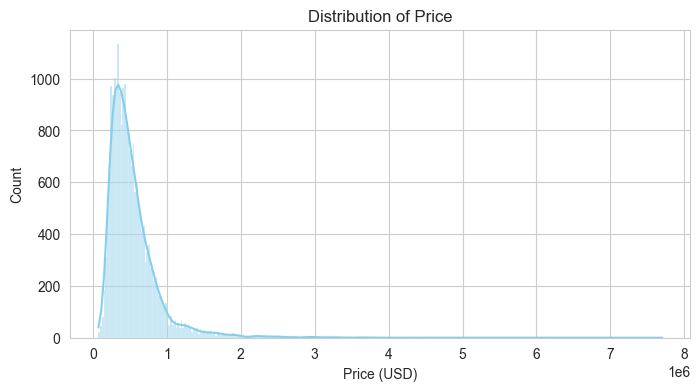

In [17]:
plt.figure(figsize=(8,4))
sns.histplot(data['price'], kde=True, color='skyblue')
plt.title("Distribution of Price")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()


### 6.2 特徴量間の相関関係

`days_since_2014_01_01`、`renovated_flag`、`years_since_renovation` を含めて相関行列を再確認し、モデル用特徴量間の関係を把握する。


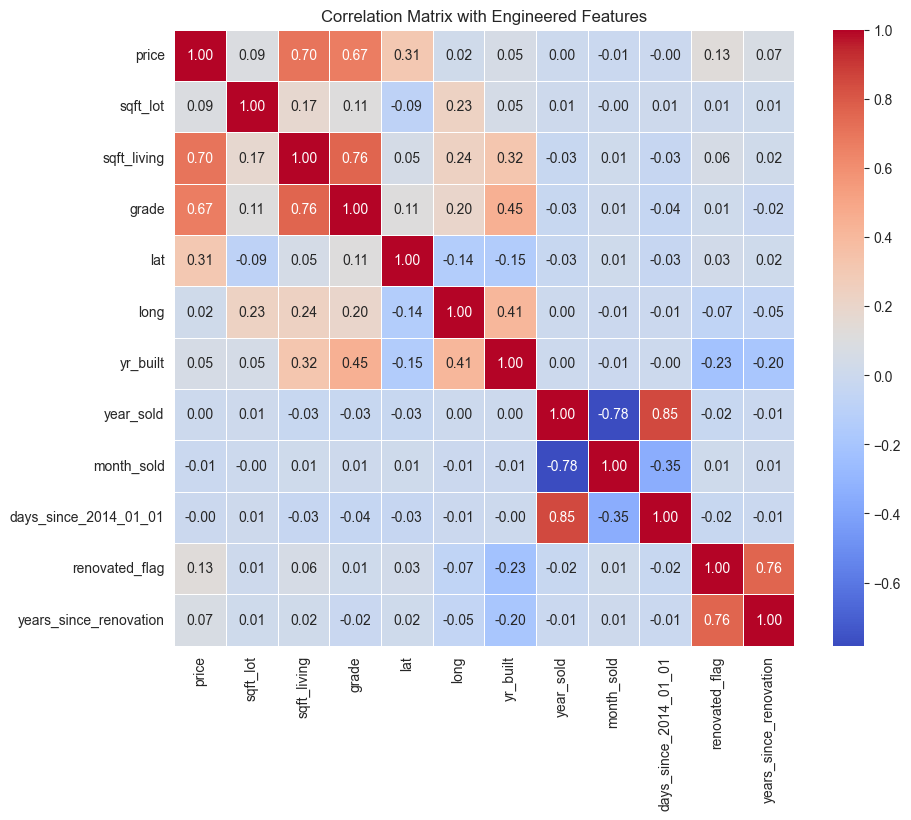

In [18]:
corr = data[numeric_cols].astype(float).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix with Engineered Features")
plt.show()
